In [124]:
import praw
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression,ElasticNetCV, Lasso, LassoCV,  Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.feature_extraction import text

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import re

from jupyterthemes import jtplot
jtplot.style()

pd.options.display.max_colwidth = 400

# Load Data

In [129]:
path = '../project_3/ALvsST.csv'

df = pd.read_csv(path)
df.head()

,title,id,body,subreddit
0,,jeatww,,0
1,,jea1j3,,0
2,1 astral project fly to a different planet fly into alien home haunt the alien fly back to your body wake up come to term with the fact u just scared an alien,je9nz7,1 astral project fly to a different planet fly into alien home haunt the alien fly back to your body wake up come to term with the fact u just scared an alien,0
3,several month ago ive taken time to let this sink in i wa practicing meditation on a daily basis and had a vision of an et woman during a meditation i wa only trying to relax not make any sort of contact so the experience ha shocked me out of meditation practice ever since an extraordinarily clear image had come into my mind of this woman i can hardly imagine any person or thing in my mind in ...,je84qo,several month ago ive taken time to let this sink in i wa practicing meditation on a daily basis and had a vision of an et woman during a meditation i wa only trying to relax not make any sort of contact so the experience ha shocked me out of meditation practice ever since an extraordinarily clear image had come into my mind of this woman i can hardly imagine any person or thing in my mind in ...,0
4,think about it if i talk about certain thing then make some thing up the abc agency will prolly go like “ayy lmao he’s a shill”,je5wtj,think about it if i talk about certain thing then make some thing up the abc agency will prolly go like “ayy lmao he’s a shill”,0


# PreProcessing + Modeling

In [153]:
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 63,
                                                    stratify = y )


my_stop_words = text.ENGLISH_STOP_WORDS.union(["ha",'wa','im','doe'])

tf = TfidfVectorizer(stop_words=my_stop_words)

tf.fit(X_train)

X_train_tf = tf.transform(X_train)

X_test_tf = tf.transform(X_test)

In [155]:
#pgrid = {"C": np.linspace(0.0001, 1, 20)}
#https://github.com/josephofiowa/zenzic/blob/master/obama-onion/obama-onion-analysis.ipynb

svc = SVC(probability=True)

gamma_range = 10.**np.arange(-5, 2)
C_range = 10.**np.arange(-2, 3)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)
cv_folds = StratifiedKFold(shuffle=True,random_state=42)

grid = GridSearchCV(svc, param_grid, cv=cv_folds, scoring='accuracy')

grid.fit(X_train_tf, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             scoring='accuracy')

# Evaluate Model Metrics

In [156]:
grid.best_params_

{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [157]:
grid.best_score_

0.9826869059441055

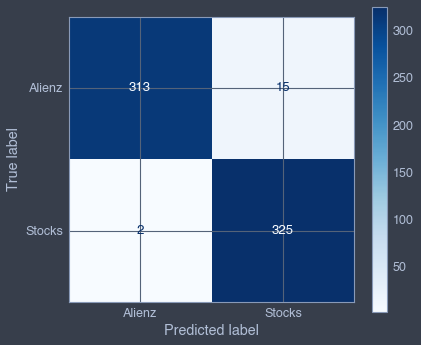

In [159]:
# Generate predictions.
preds = gs2.predict(X_test_tf)

plot_confusion_matrix(gs2, X_test_tf, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Alienz', 'Stocks']);

In [160]:
y_test.value_counts()

0    328
1    327
Name: subreddit, dtype: int64

In [161]:
#Generate predictions
preds = gs2.predict(X_test_tf)
pred_proba = gs2.predict_proba(X_test_tf)[:,1]

def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Predicted Alienz', 'Predicted Stonks'], 
                            columns=['Actual Alienz', 'Actual Stonks']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))

In [162]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.9740458015267176  

----------------------------------------------------------------
                  Actual Alienz  Actual Stonks
Predicted Alienz            313             15
Predicted Stonks              2            325 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       328
           1       0.96      0.99      0.97       327

    accuracy                           0.97       655
   macro avg       0.97      0.97      0.97       655
weighted avg       0.97      0.97      0.97       655

-----------------------------------------------------------------
ROC_AUC SCORE 0.9988532110091742 


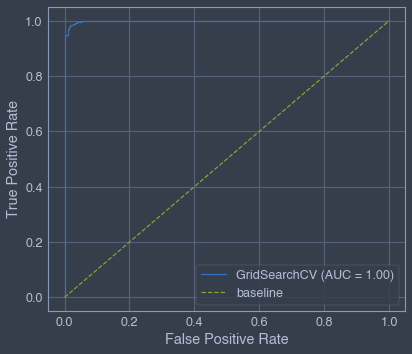

In [165]:
plot_roc_curve(gs2, X_test_tf, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();